<h3><b>Importing Library</b></h3>

In [1]:
#Importing Library
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import keras
import numpy as np
import cv2
from keras import optimizers
from __future__ import print_function
from keras.datasets import cifar100
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf
from keras.utils import to_categorical

<h3><b>Importing Dataset</b></h3>

In [2]:
CLASSES = 100
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

169009152/169001437 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


<h3><b>Preprocessing of the Dataset</b></h3>

In [3]:
#Normalize the Dataset
X_train = X_train/255
X_test = X_test/255

In [4]:
#Converting the testing and training dataset into float
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')


In [5]:
# Convert training and the test labels to one hot matrices
y_train = keras.utils.to_categorical(y_train, 100)
y_test = keras.utils.to_categorical(y_test, 100)
print(y_train.shape)

(50000, 100)


<h3><b>Model Architecture</b></h3>

<h4><b> Identity Block</b><h4>

In [6]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'same', name = conv_name_base + '2a')(X)
    # X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('elu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b')(X)
    # X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('elu')(X)


    # Final step: Add shortcut value to main path, and pass it through a ELU activation
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)

    return X

<h4><b>Convolutional Block</b></h4>

In [7]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2= filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a',padding="same")(X)
    # X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('elu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b')(X)
    # X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('elu')(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F2, (1, 1), strides = (s,s), name = conv_name_base + '1',padding = 'same')(X_shortcut)
    # X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a ELU activation
    X = Add()([X, X_shortcut])
    X = Activation('elu')(X)
    
    return X

<h4><b>Resnet Block</b></h4>

In [8]:
def ResNet18(input_shape = (32, 32, 3), classes = 100):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7),padding = "same" ,strides = (2, 2), name = 'conv1')(X)
    # X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('elu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64], stage=2, block='b')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128], stage=3, block='b')
   
    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256], stage=4, block='b')
  
    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512], stage=5, block='b')

    # AVGPOOL.
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

<h4><b>Compile the Model</b></h3>

In [9]:
model = ResNet18(input_shape = (32, 32, 3), classes = CLASSES)

In [10]:

learning_rate = 0.00001
batch_size = 128
lr_decay = 1e-6
#optimization details
opt = optimizers.Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

<h3><b>Model Checkpoint and Early Stopping</b></h3>

In [11]:
# Create Checkpoint and Early Stopping
from keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint("Resnet18_Adam_NoRegularization.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

<h3><b> Train the Model </b></h3>

In [12]:
batch_size = 128
history = model.fit(X_train, y_train ,validation_data=(X_test, y_test), epochs=100,callbacks=[checkpoint,early])

Epoch 1/100
1563/1563 [==============================] - ETA: 0s - loss: 4.0528 - accuracy: 0.0886
Epoch 00001: val_loss improved from inf to 3.65238, saving model to Resnet18_Adam_NoRegularization.h5
1563/1563 [==============================] - 23s 15ms/step - loss: 4.0528 - accuracy: 0.0886 - val_loss: 3.6524 - val_accuracy: 0.1481
Epoch 2/100
1561/1563 [============================>.] - ETA: 0s - loss: 3.5123 - accuracy: 0.1736
Epoch 00002: val_loss improved from 3.65238 to 3.41219, saving model to Resnet18_Adam_NoRegularization.h5
1563/1563 [==============================] - 22s 14ms/step - loss: 3.5122 - accuracy: 0.1736 - val_loss: 3.4122 - val_accuracy: 0.1902
Epoch 3/100
1561/1563 [============================>.] - ETA: 0s - loss: 3.3428 - accuracy: 0.2005
Epoch 00003: val_loss improved from 3.41219 to 3.29562, saving model to Resnet18_Adam_NoRegularization.h5
1563/1563 [==============================] - 22s 14ms/step - loss: 3.3426 - accuracy: 0.2006 - val_loss: 3.2956 - val_a

In [13]:
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 19, 19, 64)   9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
activation (Activation)         (None, 19, 19, 64)   0           conv1[0][0]                      
___________________________________________________________________________________________

<h3><b>Graph</b><h3>

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


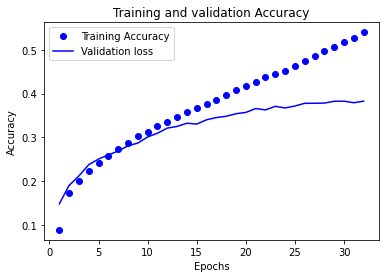

In [14]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, accuracy_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label='Validation loss')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


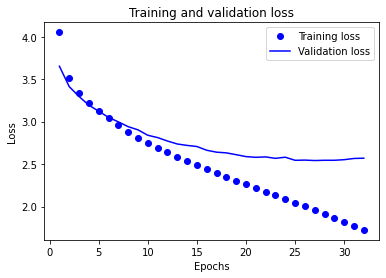

In [15]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


<h3><b> Model save Metric Calculation</b></h3>

In [18]:
model1 = ResNet18(input_shape = (32,32,3), classes = CLASSES)
model1.load_weights("./Resnet18_Adam_NoRegularization.h5")
learning_rate = 0.001
batch_size = 128
lr_decay = 1e-6

#optimization details
learning_rate = 0.0001
batch_size = 128
lr_decay = 1e-6
#optimization details
opt = optimizers.Adam(lr=learning_rate)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

# Test the model
model.predict(X_test).argmax(-1)

y_true = y_test.argmax(-1)
y_pred = model.predict(X_test).argmax(-1)
# generate confusion matrix
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
confusion_matrix(y_true, y_pred)
# calculate prec, recall, accuracy
print("Prec: "+ str(precision_score(y_true, y_pred, average='weighted')))
print("Recall: "+ str(recall_score(y_true, y_pred, average='weighted')))
print("Accuracy: " + str(accuracy_score(y_true, y_pred)))

Prec: 0.3949441830683419
Recall: 0.3827
Accuracy: 0.3827


<h3><b>References</b></h3>

In [17]:
#https://github.com/priya-dwivedi/Deep-Learning/blob/master/resnet_keras/Residual_Networks_yourself.ipynb
#https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/applications/resnet.py
#https://github.com/deep-diver/DeepModels
